# Train Cifar100 on piano

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

In [16]:
dataset = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [17]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

## Plot some examples

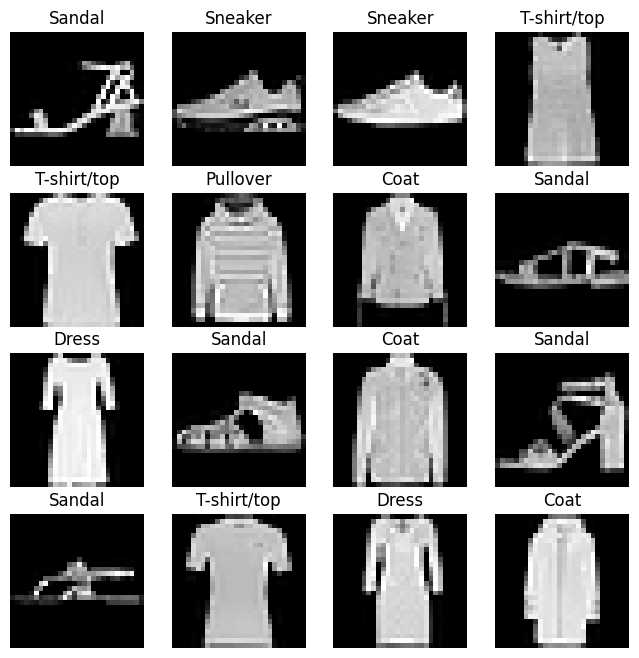

In [19]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4

for i in range(1, rows*cols + 1):
    data, label_idx = dataset[np.random.randint(0, len(dataset))]
    # data is 3, 28, 28, but permute to 28, 28, 3 for display
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(data.permute(1, 2, 0), cmap='grey')
    plt.title(dataset.classes[label_idx])
plt.show()

## prepare data flow

In [235]:
data_loader = DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=False,
)

In [236]:
for X, y in data_loader:
    print(f"X shape {X.shape}")
    print(f"y shape {y.shape}: {y}")
    break

X shape torch.Size([64, 1, 28, 28])
y shape torch.Size([64]): tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


## setup a naive neural network

In [291]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(dataset.classes)),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [292]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [293]:
len(data_loader.dataset)

60000

In [294]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            reset_midi()
            play_sound()
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [282]:
import time

In [283]:
out.send(mido.Message('note_on', note=60, velocity=10))

In [284]:
def reset_midi():
    out.send(mido.Message('control_change', channel=0, control=123))

In [295]:
def play_sound(how_many = 1, show_fig=False):
    model.eval()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        if show_fig:
            plt.imshow(X[0].cpu().permute(1, 2, 0))
            plt.show()
    
        preds = nn.Softmax(dim=1)(model(X))
        break

    for pred in preds[0:how_many]:
        print(pred.tolist())
        for i, p in enumerate(pred):
            midi_msg = mido.Message('note_on', note=50 + (i*3), velocity=int(np.clip(float(p)*127, 0, 80)))
            out.send(midi_msg)
            # time.sleep(0.01)
        time.sleep(0.5)
        reset_midi()

    return pred

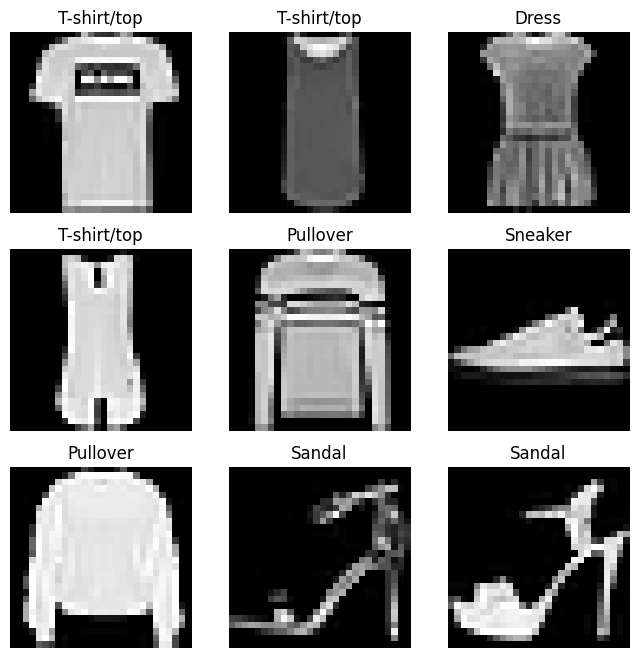

In [286]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, rows*cols + 1):
    data, label_idx = dataset[i]
    # data is 3, 28, 28, but permute to 28, 28, 3 for display
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(data.permute(1, 2, 0), cmap='grey')
    plt.title(dataset.classes[label_idx])
plt.show()

In [287]:
x = play_sound()

[0.0001846423401730135, 5.665089702233672e-05, 0.0013145963894203305, 0.0003346183802932501, 0.001678589847870171, 0.1145762950181961, 0.0010095223551616073, 0.07270961254835129, 0.09411768615245819, 0.7140177488327026]


In [297]:
reset_midi()

In [296]:
epochs = 50
for t in range(epochs):
    # play_sound()
    print(f"Epoch {t+1}\n-------------------------------")
    train(data_loader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
    # reset_midi()
reset_midi()
print("Done!")

Epoch 1
-------------------------------
[0.09889113157987595, 0.1072334498167038, 0.09541130065917969, 0.10730839520692825, 0.09736113995313644, 0.0958247035741806, 0.09970526397228241, 0.1096319854259491, 0.089435875415802, 0.09919672459363937]
loss: 2.317163  [   64/60000]
[0.09827928245067596, 0.1049739271402359, 0.09732195734977722, 0.10512547940015793, 0.09910904616117477, 0.09350898116827011, 0.09979481250047684, 0.1081763505935669, 0.09180991351604462, 0.10190028697252274]
loss: 2.305650  [ 6464/60000]
[0.09753289818763733, 0.10219632089138031, 0.09860863536596298, 0.10280876606702805, 0.10128019750118256, 0.09153808653354645, 0.10076598823070526, 0.10655664652585983, 0.0938134491443634, 0.10489901155233383]
loss: 2.288429  [12864/60000]
[0.09723088890314102, 0.09993654489517212, 0.09953796118497849, 0.10123316943645477, 0.10234524309635162, 0.08991851657629013, 0.10081549733877182, 0.10561257600784302, 0.0956716388463974, 0.10769796371459961]
loss: 2.277396  [19264/60000]
[0.09

KeyboardInterrupt: 

In [188]:
reset_midi()

In [187]:
out.send(mido.Message('note_on', note=24, velocity=20))

In [112]:
!pip install scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/18/44/7e8d208eb59a8224fcc474415104f13be9b378be8da63f76dfde12ec2b44/scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 744.1 kB/s eta 0:00:00MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 22.7 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [113]:
import scipy

In [116]:
scipy.special.log_softmax([7.9030e-06, 1.0666e-06, 1.6441e-04, 1.7155e-05, 2.1171e-04, 1.6600e-01,
        1.6971e-04, 4.3639e-02, 1.4971e-01, 3.2448e-01]) * 127

array([-301.85467576, -301.85554399, -301.83479937, -301.85350076,
       -301.82879227, -280.77367944, -301.83412627, -296.31352644,
       -282.84250944, -260.64671944])

In [42]:
!pip install mido

  Obtaining dependency information for mido from https://files.pythonhosted.org/packages/b0/0e/b551e09391220208764c00ed2b382e198414329d8b6037eeb54a8008d737/mido-1.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.1 MB/s eta 0:00:001.1 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import mido

In [3]:
mido.backend

<backend mido.backends.rtmidi (loaded)>

In [4]:
mido.get_output_names()

['Midi Through:Midi Through Port-0 14:0',
 'MIDILINK-mini:MIDILINK-mini MIDI 1 24:0']

In [9]:
out = mido.open_output("MIDILINK-mini MIDI 1")

In [13]:
midi_msg = mido.Message('note_off', note=60, velocity=20)

In [14]:
out.send(midi_msg)

In [46]:
!pip3 install --pre python-rtmidi

  Obtaining dependency information for python-rtmidi from https://files.pythonhosted.org/packages/26/a0/af83b72085164052808971607ea90b8d5aa78110c5d6d8feec3df25e0cd0/python_rtmidi-1.5.7-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.3/765.3 kB 8.1 MB/s eta 0:00:008.5 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
mido.get_output_names()

ALSA lib conf.c:4005:(snd_config_hooks_call) Cannot open shared library libasound_module_conf_pulse.so (/usr/lib64/alsa-lib/libasound_module_conf_pulse.so: cannot open shared object file: No such file or directory)
ALSA lib seq.c:935:(snd_seq_open_noupdate) Unknown SEQ default


SystemError: MidiInAlsa::initialize: error creating ALSA sequencer client object.